### Introduction

Here I'm developing code from the A2C algorithm. I'm trying out a version where the Q-function
has two arguments, Q(s,a), and one output, as opposed to the usual. Also, trying out having the actor loss

grad J = grad (ln(pi) ) * Q(s,a)

And I'm using a NN for the Q-function. I'm updating this every timestep. Not sure will this work.

### Test

/home/kokeeffe/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


WARN: gym.spaces.Box autodetected dtype as <type 'numpy.float32'>. Please provide explicit dtype.
(episode, score) = (50, 20.0)
(episode, score) = (100, 17.0)
(episode, score) = (150, 22.0)
(episode, score) = (200, 15.0)
(episode, score) = (250, 13.0)
(episode, score) = (300, 11.0)
(episode, score) = (350, 44.0)
(episode, score) = (400, 11.0)


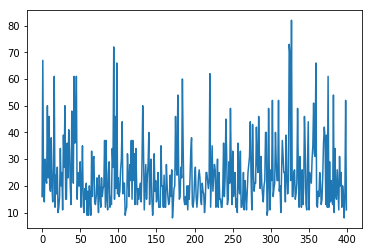

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from agent import Agent
%matplotlib inline



#Environment
env = gym.make('CartPole-v0')
env.seed(0)
input_dim = env.observation_space.shape[0]
output_dim = env.action_space.n


#Agent
lr,gamma,tau = 0.0001, 0.99, 0.1
clipnorm, verbose = False, False
agent = Agent(input_dim, output_dim, lr, gamma, tau, clipnorm, verbose)


#Train
EPISODES = 400
scores = []
for e in range(1,EPISODES+1):
    state = env.reset()
    state = agent.make_tensor(state)
    reward_sum = 0
    done = False
    while not done:
        
        #Do main step
        # env.render()
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        reward_sum += reward
        next_state = agent.make_tensor(next_state)
        agent.remember(state[0],action,reward,next_state[0],done) #want to remember state as a vec
        
        #Learn
        if e > 100:
            agent.learn()
            
        state = next_state
        if done:
            break
    
    #Learn & print results
    scores.append(reward_sum)
    if e % 50 == 0:
        print '(episode, score) = ' + str((e,reward_sum))
plt.plot(scores)

### Debug